# Example notebook: how to fit experimental data to the Michaelis-Menten equation

In biochemistry, Michaelis–Menten kinetics is one of the best-known models of enzyme kinetics. The model takes the form of an equation describing the rate of enzymatic reactions, by relating reaction rate $v$ to [S], the concentration of a substrate $S$. The most useful form of the equation for the working biochemist relates the quotient of velocity observed $v$ and enzyme concentration $[E]$ to the catalytic rate $k_cat$ and the pseudo$$v/[E]=\frac{k_{cat}*[S]}{K_M + [S]}$$

This notebook is a tutorial for the experimental biochemist who has collected data comprising the rate of product formation under different concentrations of substrate, as we frequently do in the [Siegel group](https://sites.google.com/site/ucdsiegellab/). Let's begin with data workup. 

## Data workup 

In a few steps, we'll work up our data for fitting. 

1. Convert your rates from OD/min into M/min (molar per minute) using a standard curve. 
1. Convert your enzyme concentration from mg/mL into M by dividing by the extinction coefficient of the protein and correcting for any dilution in your assay procedure 
1. Finally, divide the rates you observe (in units of M/min) by the enzyme concentration that you are testing (in units of M), to obtain rates in min$^{-1}$
1. Convert your substrate concentrations into M as well
1. Put them in a CSV table like the one in this repository called `example_data.csv` 

## Make a plot of your data

Let's generate a plot of our data using the Python package `matplotlib` to see if it will fit the Michaelis-Menten equation.

First, let's import the packages we'll need and do some iPython magic to get the plots to display on this page.

In [6]:
import pandas
%matplotlib inline 

Next, we'll read in the example data into a [Pandas](http://pandas.pydata.org) `DataFrame`, a data structure similar to a table that's a whole lot smarter and more useful. You can call the `DataFrame` whatever you like. I'll call this one `df`. 

In [7]:
df = pandas.read_csv( 'example_data.csv' )

Now that we have our data in a `DataFrame`, we can use the built-in method `plot()` of the `DataFrame` to make a quick scatter plot of our data and display it on screen.

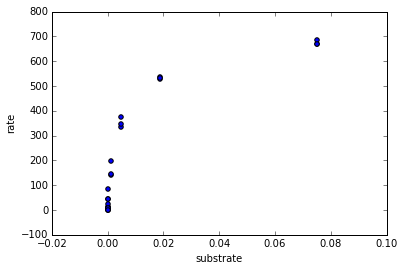

In [9]:
df.plot( x='substrate', y='rate', kind='scatter' )

That looks like it will fit the Michaelis-Menten equation really well!

## Fit your data to the Michaelis-Menten equation to determine $k_{cat}$ and $K_M$

Next, we'll use the Python module [SciPy](http://www.scipy.org) to perform a nonlinear least-squares optimization to determine the values of $k_{cat}$ and $K_M$ that fit our data best. First, we'll import SciPy and a couple of Numpy modules that we'll need later 

In [29]:
from scipy.optimize import curve_fit 
from numpy import diag, sqrt

and define the Michaelis-Menten equation in Python code 

In [30]:
def v( s, kcat, km ):
    return ( kcat * s ) / ( km + s )

We need to provide `curve_fit` with initial estimates of the parameters, which we can estimate from the scatter plot above. The value for $k_{cat}$ (the maximum rate observed) appears to be about 650 min$^{-1}$, and the value for $K_M$ (the point at which the velocity is half of $k_{cat}$ looks to be about 0.005. We'll define a new tuple, called `p0`, with these values

In [31]:
p0 = ( 650, 0.005 )

Now we're ready to use `curve_fit`. [The `curve_fit` documentation](http://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.curve_fit.html) indicates that the function returns two arrays, called `popt` (= parameter optimums) and `pcov` (= parameter covariance). From the documentation:

> **popt** : array
> Optimal values for the parameters so that the sum of the squared error of f(xdata, *popt) - ydata is minimized

> **pcov** : 2d array
> The estimated covariance of popt. The diagonals provide the variance of the parameter estimate. To compute one standard deviation errors on the parameters use perr = np.sqrt(np.diag(pcov)).
How the sigma parameter affects the estimated covariance depends on absolute_sigma argument, as described above.

I recommend setting up your code to have the function return into two variables called `popt` and `pcov`.

In this next step, we'll perform the optimization and catch the output variables into human-readable names. 

In [46]:
popt, pcov = curve_fit( v, df.substrate, df.rate, p0=p0 )
perr = sqrt( diag( pcov ) )

# rename them to something readable 
kcat = popt[0]
km = popt[1]

# calculate standard errors
for i in [ 0, 1 ]:
    if not popt[ i ] or perr[ i ] > popt[ i ]:
      popt[ i ] = perr[ i ] = None 
    else:
      perr[ i ] = perr[ i ] / popt [ i ] * 100
    
percent_err_kcat = perr[0]
percent_err_km = perr[1]

Whew! That's it! Let's print out our results in a nice format, rounding numbers as necessary

In [53]:
print 'The kcat determined for these data is {:0.0f} ± {:0.1f}%'.format( kcat, percent_err_kcat )
print '{:0.4f} ± {:0.1f}%'.format( km, percent_err_km )

693 ± 1.8%
0.0045 ± 7.2%
